In [1]:
%reset
%matplotlib inline

import netCDF4 as nc
import cmocean
import numpy as np
import xarray as xr
import xrft
from xgcm import Grid
import matplotlib.pyplot as plt
import scipy.interpolate
from dask.diagnostics import ProgressBar
from matplotlib import colors, ticker
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [6]:
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
forcing=xr.open_dataset('NW2_forcing.nc', decode_times=False) #This is for the 1/8 degree case

#1/32 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_dataset('sub20/ocean.stats.nc', decode_times=False)
av = xr.open_dataset('averages_00002702.nc', decode_times=False)  #20 5-day averages

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis
/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [7]:
lat= (av.yh)     
lon= (av.xh)     

u= av.u[:,0,:,:]-(av.u[:,0,:,:].mean('time')) #We're removing the temporally-averaged mean flow.
v= av.v[:,0,:,:]-(av.v[:,0,:,:].mean('time'))
Ld = av.Rd1[:].mean('time')
grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
#Interpolating u,v to be on the same grid points:
dx= grid.interp(fs.dxCu,axis='X')
dy= grid.interp(fs.dyCv,axis='Y')
u = grid.interp(u,axis='X')
v = grid.interp(v,axis='Y')
print(u.shape,v.shape)
Ld = av.Rd1[:].mean('time')

(20, 4480, 1920) (20, 4480, 1920)


In [8]:
print('min dx:',2*np.pi*6378000*np.cos(70*np.pi/180)/360/32,'km')
print('max dx:',2*np.pi*6378000/360/32,'km')

min dx: 1189.7715747288576 km
max dx: 3478.6593653811983 km


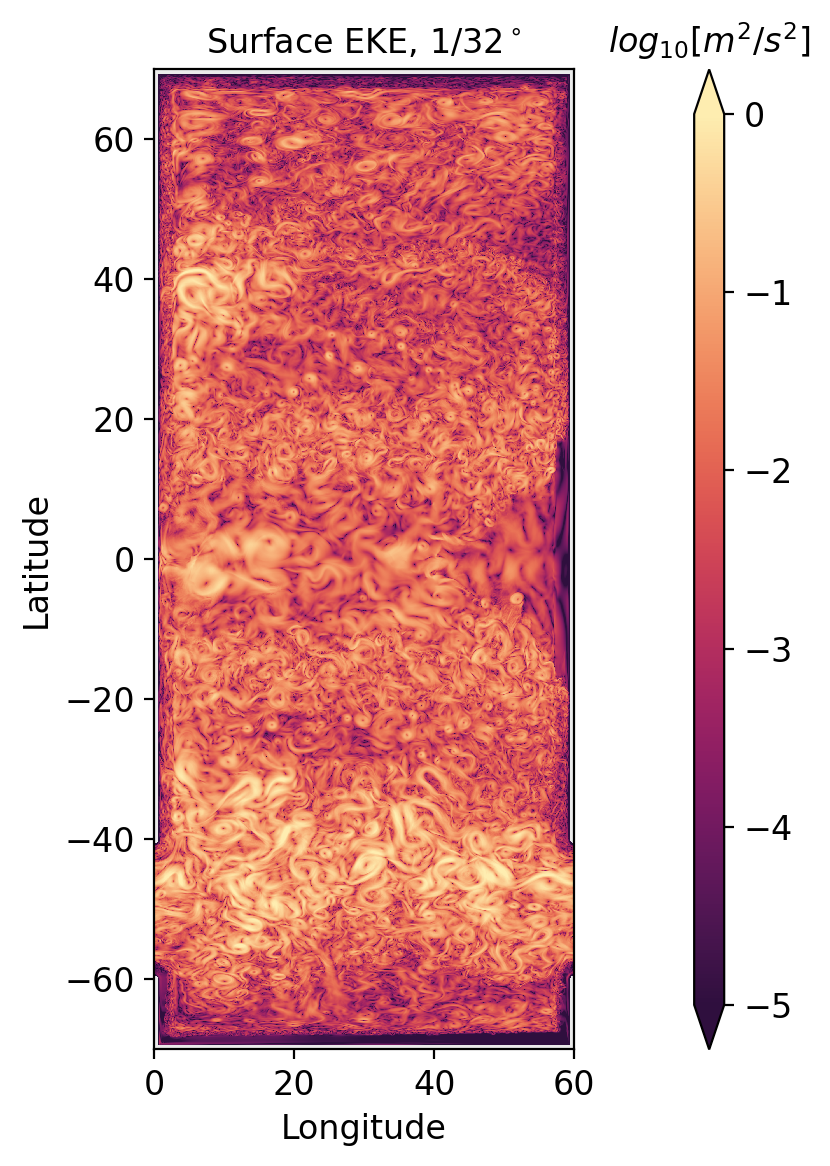

In [10]:
#Plotting KE for whole domain
fig = plt.figure(figsize=(5, 7), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=12)
ax1.set_ylabel('Latitude',fontsize=12)
ax1.tick_params(labelsize=12); 
ax2.tick_params(labelsize=12)


ax1.set_title('Surface EKE, 1/32$^\circ$',fontsize=12)

KE=(u**2+v**2)*0.5
plotted =ax1.pcolor(lon[:],lat[:],np.log10(KE[-1,:,:]),cmap=cmocean.cm.matter_r,vmin=-5,vmax=0, shading='auto')
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical',extend='both');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$log_{10}[m^2/s^2]$')
#
plt.show()

### Computing the 1D spectrum at one latitude

In [76]:
xi=dx.cumsum(axis=1)-dx[:,0] #subtract first dx so that we start at x=0m.
time=np.arange(0,1,1)

boundary=50 #50
i=75
    
xline= xi[i,boundary:-boundary]
uline= u[time,i,boundary:-boundary].fillna(0.); uline=uline.assign_coords(xh=xline) 
vline= v[time,i,boundary:-boundary].fillna(0.); vline=vline.assign_coords(xh=xline)
Ldline= Ld[i,boundary:-boundary]; Ldline=Ldline.assign_coords(xh=xline)
    
uiso2 = xrft.power_spectrum(uline,dim=['xh'], scaling="density",window='hamming', detrend='linear').compute() #, window='hann/hamming', detrend='linear'
viso2 = xrft.power_spectrum(vline,dim=['xh'], scaling="density",window='hamming', detrend='linear').compute()
ekeiso = .5*(uiso2 + viso2).mean('time') #Computing the mean spectrum first, then finding max wavenumber later.
nk = int(len(ekeiso)/2.)

ekeiso=ekeiso[nk+1:]    # half of the latitude array size
wavenumber= (ekeiso.freq_xh*1e3*2*np.pi)
LD_wavenumber=(1/(Ldline/1000)).mean('xh')
ES_wavenumber=ekeiso[3:].idxmax(dim='freq_xh')*1000*2*np.pi #don't count first 3 wavenumbers
  
alt_PS=0.5*(np.abs(np.fft.rfft(uline))**2)+0.5*(np.abs(np.fft.rfft(vline))**2) #units m2/s2
alt_PS=alt_PS*np.array(dx[i,100]/len(xline)) #if using scaling density, units m3/s2
alt_freq= np.fft.rfftfreq(uline.size,np.array(dx[i,100])/(1000*2*np.pi))
    
centroid = np.nansum(ekeiso*wavenumber)/np.nansum(ekeiso)
    

Text(0, 0.5, '[m$^3$ s$^{-2}$]')

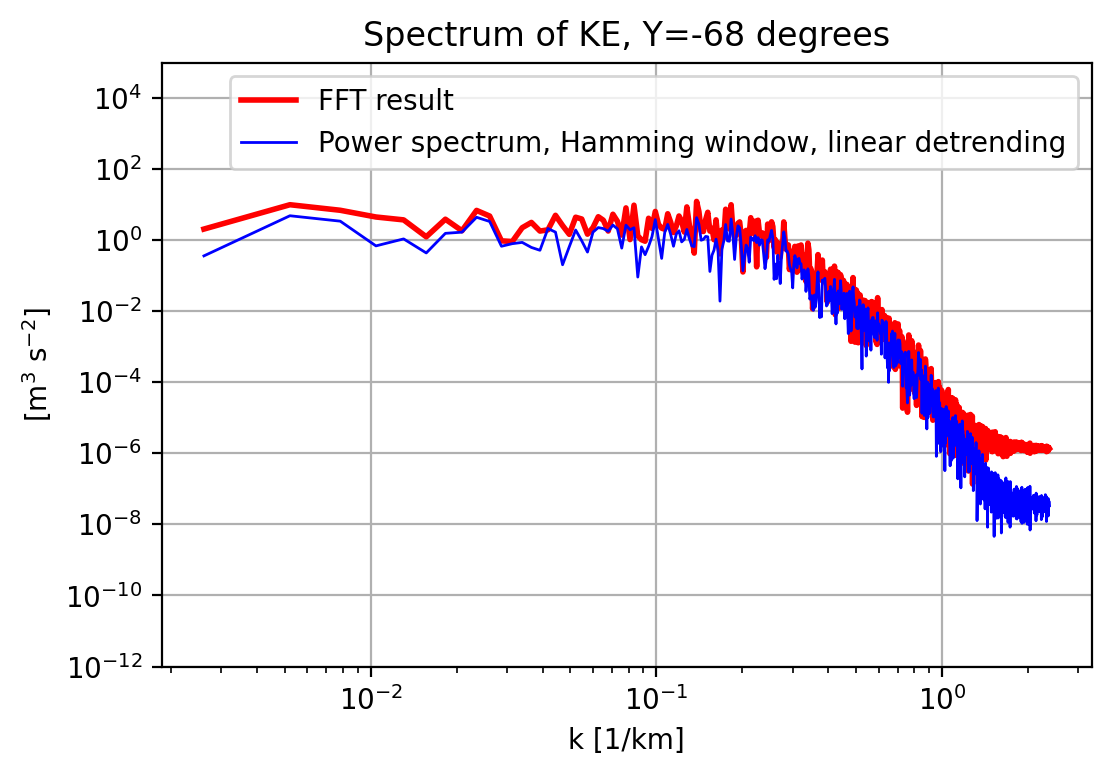

In [78]:
fig, ax = plt.subplots(figsize=(6,4),dpi=200)


plt.plot(alt_freq[1:],alt_PS[0,1:],'-r',linewidth=2,label='FFT result')  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber
plt.plot(wavenumber,ekeiso,'-b',linewidth=1,label='Power spectrum, Hamming window, linear detrending')  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber

#l1=plt.plot([ES_wavenumber,ES_wavenumber], [1e-12,1e5],color='k',label='$k_E=$ 1/(%.1f km)'%(1/ES_wavenumber))
#l2=plt.plot([LD_wavenumber,LD_wavenumber], [1e-12,1e5],':k',linewidth=3,label='$k_D$ = 1/(%.1f km)'%(1/LD_wavenumber))
#l2=plt.plot([centroid,centroid], [1e-12,1e5],'--k',linewidth=3,label='centroid = 1/(%.1f km)'%(1/centroid))

plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE, Y=%.0f degrees'%lat[i])
plt.ylim([1e-12, 1e5])
#plt.xlim([1e-4, 1e1])
plt.grid()
plt.xlabel('$\kappa_r (1/km)$')
plt.legend(fontsize=10)

ax.set_xlabel(r'k [1/km]')
ax.set_ylabel(r'[m$^3$ s$^{-2}$]')